In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import math
from scipy import stats

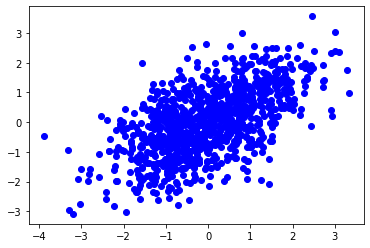

In [7]:
cov = 1/4 * np.array([[5,3],[3,5]]) # det(cov) = 1 and has eigenvalues 2 and 1/2
data = np.random.multivariate_normal([0,0], cov, 1000)
plt.plot(data[:,0], data[:,1], 'bo')

{'boxes': [<matplotlib.lines.Line2D at 0x7faf1b011fd0>,
 'caps': [<matplotlib.lines.Line2D at 0x7faf1afa19b0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7faf1afa93c8>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7faf1afa9080>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7faf1afa1320>,
  <matplotlib.lines.Line2D at 0x7faf1ae6fa20>]}

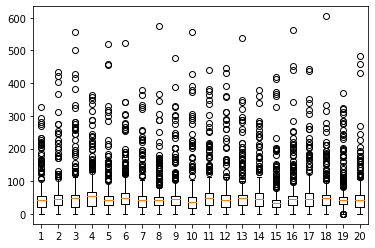

In [45]:
# Does a linear CDF model do better on high variance normal or low variance normal?
# I'd assume high variance, since the normal distribution "approaches" uniform as the variance tends to infinity

n = 1000

def regress(var):
    x = np.sort(np.random.normal(0, var, n))
    y = np.arange(n)
    reg = stats.linregress(x,y)

    
    t = [abs(reg.intercept + reg.slope * x - y) for x,y in zip(x,y)]
    return t


variances = np.arange(1,200,10)
ts = np.array([regress(var) for var in variances])
plt.boxplot([t for t in ts])

# The data shows that my assumption is wrong. It doesn't matter if the variance is higher
# for the normal distribution. This makes sense in hindsight, since the CDF of the normal will look
# the same regardless of the variance.


[52, 29, 35, 40, 55, 44, 50, 67, 53, 56, 69, 72, 77, 56, 56, 41, 42, 26, 19, 61]
[61, 17, 25, 37, 42, 49, 65, 62, 70, 81, 77, 60, 55, 61, 55, 39, 33, 30, 25, 56]
[57, 22, 28, 39, 37, 57, 63, 56, 65, 77, 74, 60, 58, 63, 62, 52, 23, 29, 22, 56]
[59, 19, 24, 44, 34, 55, 61, 63, 72, 58, 74, 67, 72, 59, 41, 51, 40, 35, 20, 52]
[59, 19, 25, 39, 40, 44, 52, 76, 74, 71, 84, 68, 62, 56, 40, 47, 39, 33, 22, 50]
[54, 24, 35, 42, 45, 48, 66, 63, 55, 68, 57, 67, 71, 66, 48, 37, 31, 40, 26, 57]
[52, 21, 29, 30, 46, 57, 61, 79, 65, 79, 66, 66, 60, 61, 49, 34, 34, 28, 24, 59]
[59, 21, 29, 29, 46, 53, 53, 69, 66, 77, 66, 71, 70, 60, 50, 41, 30, 30, 23, 57]
[50, 20, 27, 44, 42, 54, 42, 66, 77, 80, 74, 81, 61, 47, 55, 38, 35, 33, 23, 51]
[49, 21, 35, 28, 46, 52, 72, 67, 78, 75, 60, 60, 74, 59, 47, 37, 27, 28, 27, 58]
[52, 25, 35, 42, 37, 42, 48, 55, 87, 80, 73, 71, 59, 59, 52, 53, 29, 19, 28, 54]
[59, 24, 16, 33, 54, 51, 51, 64, 86, 68, 58, 84, 63, 48, 53, 33, 47, 31, 22, 55]
[59, 21, 22, 36, 42, 75, 56,

{'boxes': [<matplotlib.lines.Line2D at 0x7faf1a83a860>,
 'caps': [<matplotlib.lines.Line2D at 0x7faf1a849240>,
 'fliers': [<matplotlib.lines.Line2D at 0x7faf1a849c18>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7faf1a8498d0>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7faf1a83ab70>,
  <matplotlib.lines.Line2D at 0x7faf1a6facc0>]}

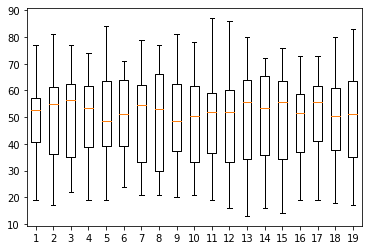

In [59]:
# This shows that the partitons are not better as the variance increases
# This reinforces the hypothesis in the above cell that using PCA to choose
# a projection hyperplane won't help if the data is multivariate Gaussian

n = 1000
fanout = 20


def test(var):
    xs = np.sort(np.random.normal(0, var, n))
    ys = np.arange(n)
    reg = stats.linregress(xs,ys)
    def regress(x):
        return x * reg.slope + reg.intercept
    
    # fanout must be at least 2 for this to work
    bounds = [[float("-inf"), n/fanout]]
    for i in range(fanout-2):
        bounds.append([n*(i+1)/fanout, n*(i+2)/fanout])
                      
    bounds.append([n*(fanout-1)/fanout, float("inf")])
    
    predictions = [regress(x) for x in xs]
    partitions = [[x for x in xs if regress(x) >= lower and regress(x) < upper] for lower,upper in bounds]
    sizes = [len(p) for p in partitions]
    print(sizes)

    return sizes


variances = np.arange(1,20)
ss = np.array([test(var) for var in variances])
plt.boxplot([s for s in ss])

Text(0.5, 0.98, 'Distribution of Bucket Sizes For Three Projection Policies for 5D Gaussian Distribution. depth=3, n=100000')

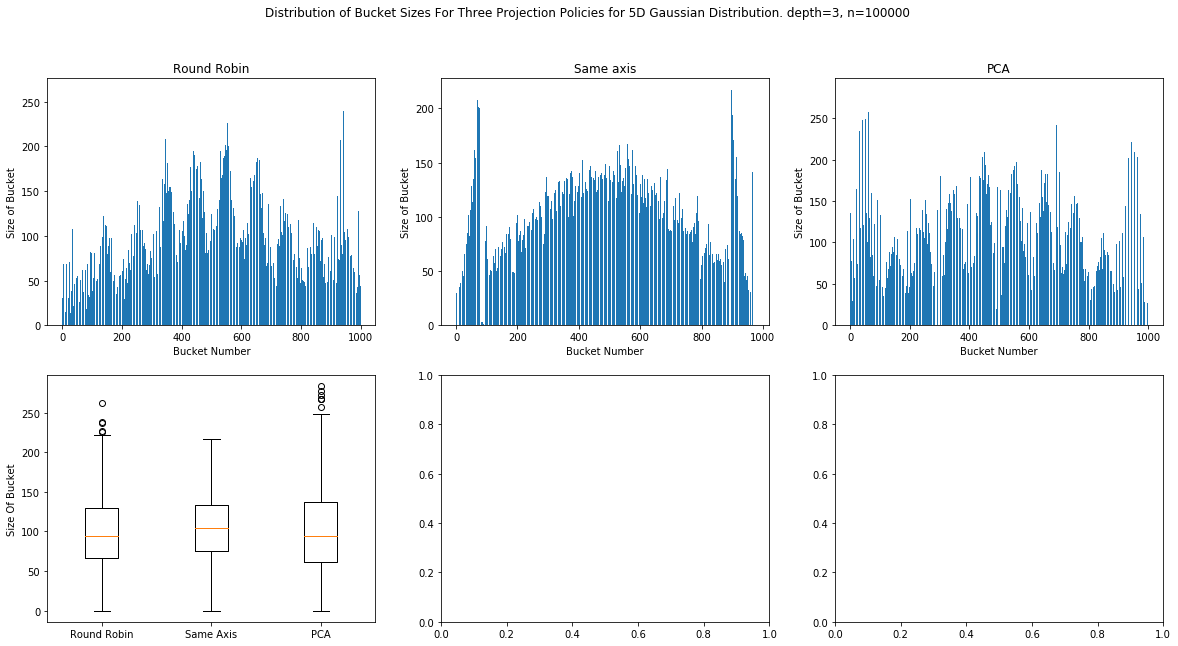

In [35]:
# Ok, now it is time to do two layer partitioning
# First using round robin


def constantProj(data, depth):
    proj = np.zeros(len(data[0]))
    proj[0] = 1
    return proj

def rrProj(data, depth):
    D = len(data[0])
    proj = np.zeros(D)
    proj[depth % D] = 1
    return proj

def pcaProj(data, depth):
    pca = PCA(n_components=1)
    pca.fit(data)
    return(pca.components_[0])

def partition(data, depth, projFn):
    if depth >= maxDepth:
        return data
    
    
    if(len(data) < 2):
        return data
    
    D = len(data[0])
    proj = projFn(data, depth)
    
    data= sorted(data, key=lambda d: np.dot(d, proj))
    xs = np.array([np.dot(d, proj) for d in data])
    
    ys = np.arange(len(xs))
    
    
    reg = stats.linregress(xs,ys)
    def regress(x):
        return x * reg.slope + reg.intercept
    
    # fanout must be at least 2 for this to work
    bounds = [[float("-inf"), len(data)/fanout]]
    for i in range(fanout-2):
        bounds.append([len(data)*(i+1)/fanout, len(data)*(i+2)/fanout])
    bounds.append([len(data)*(fanout-1)/fanout, float("inf")])
    
    
    partitions = []
    for lower,upper in bounds:
        subdata = [d for x,d in zip(xs,data) if regress(x) >= lower and regress(x) < upper]
        partitions.append(partition(subdata, depth+1, projFn))
    
    return partitions


def getSizes(partitions):
    if len(partitions) < 1 or type(partitions[0]) is not list:
        return [len(partitions)]
    else:
        sizes = []
        for p in partitions:
            sizes.extend(getSizes(p))
        return sizes
    
maxDepth = 3
fanout = 10
n = 100000

# data = np.random.multivariate_normal([0,0,0,0,0], [[1,0,0,0,0],[0,1,0,0,0],[0,0,1,0,0],[0,0,0,1,0],[0,0,0,0,1]],size=n)
data = np.random.multivariate_normal([0,0],1/4*np.array([[5,-3],[-3,5]]),n)
rrpartitions = partition(data, 0, rrProj)
rrsizes = getSizes(rrpartitions)

cpartitions = partition(data, 0, constantProj)
csizes = getSizes(cpartitions)

pcapartitions = partition(data, 0, pcaProj)
pcasizes = getSizes(pcapartitions)
        
# print(rrsizes)
# print(csizes)
# print(pcasizes)

fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_figwidth(20)
fig.set_figheight(10)


axes[0][0].bar(range(len(rrsizes)), rrsizes)
axes[0][0].set_title("Round Robin")
axes[0][0].set_xlabel("Bucket Number")
axes[0][0].set_ylabel("Size of Bucket")
axes[0][1].bar(range(len(csizes)), csizes)
axes[0][1].set_title("Same axis")
axes[0][2].bar(range(len(pcasizes)), pcasizes)
axes[0][2].set_title("PCA")
for c in range(3):
    axes[0][c].set_xlabel("Bucket Number")
    axes[0][c].set_ylabel("Size of Bucket")

axes[1][0].boxplot([rrsizes, csizes, pcasizes])
axes[1][0].set_xticklabels(["Round Robin", "Same Axis", "PCA"])
axes[1][0].set_ylabel("Size Of Bucket")

fig.suptitle("Distribution of Bucket Sizes For Three Projection Policies for 5D Gaussian Distribution. depth={}, n={}".format(maxDepth, n))
#fig.savefig("projection_policies.png")